# Notebook: BERTopic to analyse the Topics

## 1. Load Packages

In [1]:
from plots import plot_topic_subplots, plot_timeseries_subplots, plot_timeseries_sentiment_subplots
from gensim.models.ldamodel import LdaModel
from bertopic import BERTopic
from gensim import corpora
import pandas as pd
import numpy as np
import random
import torch
import math
import re
import os

/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: R2022a is an invalid version and will not be supported in a future release
  warnings.warn(


## 2. Constants / Setup

In [2]:
N_TOPICS = 26
RANDOM_STATE = 42 # default:42
TOP_N_WORDS = 100
FONT_PATH_WORDCLOUDS = 'fonts/manrope-regular.otf'
MIN_CLUSTER_SIZE = 250

In [3]:
DATASET_MENTIONS_PATH = "../Datasets/tweets_mentions_cleaned.csv"
DATASET_MENTIONS_IMG_PATH = "../Datasets/img_dataset_mentions/predictions_cleaned.csv"
DATASET_POLITICAL_ACCOUNTS_PATH = "../Datasets/tweets_political_accounts_cleaned.csv"
DATASET_POLITICAL_ACCOUNTS_IMG_PATH = "../Datasets/img_dataset_political_accounts/predictions_cleaned.csv"
MODEL_OUTPUT_PATH = "model"

In [4]:
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

In [5]:
current_directory = os.getcwd()
plots_directory = os.path.join(current_directory, 'plots')
if not os.path.exists(plots_directory):
    os.makedirs(plots_directory)
    
results_directory = os.path.join(current_directory, 'results')
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

wordclouds_directory = os.path.join(current_directory, 'wordclouds')
if not os.path.exists(wordclouds_directory):
    os.makedirs(wordclouds_directory)

## 3. Load Dataset

In [6]:
df_political_accounts = pd.read_csv(DATASET_POLITICAL_ACCOUNTS_PATH)

In [7]:
df_political_accounts_img = pd.read_csv(DATASET_POLITICAL_ACCOUNTS_IMG_PATH)

In [8]:
df_mentions_img = pd.read_csv(DATASET_MENTIONS_IMG_PATH)

In [9]:
df_mentions = pd.read_csv(DATASET_MENTIONS_PATH)

## 4. Code

#### Clean Data

In [10]:
df = df_political_accounts.copy()

In [11]:
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: '' if type(x) != str else x)
df

Unnamed: 0.1  Unnamed: 0  UserScreenName  source_account  \
0                 0           0      AfD Berlin       AfDBerlin   
1                 1           1      AfD Berlin       AfDBerlin   
2                 2           2      AfD Berlin       AfDBerlin   
3                 3           3      AfD Berlin       AfDBerlin   
4                 4           4      AfD Berlin       AfDBerlin   
...             ...         ...             ...             ...   
58859         58859       58859  Tino Chrupalla  Tino_Chrupalla   
58860         58860       58860  Tino Chrupalla  Tino_Chrupalla   
58861         58861       58861  Tino Chrupalla  Tino_Chrupalla   
58862         58862       58862  Tino Chrupalla  Tino_Chrupalla   
58863         58863       58863  Tino Chrupalla  Tino_Chrupalla   

                      date                                               Text  \
0      2021-03-26 21:07:22                AfD Berlin\n@AfDBerlin\n·\n26. März   
1      2021-03-27 07:20:27                AfD Berlin\n@AfDBerlin\n·\n27. März   
2      2021-03-31 07:14:04                AfD Berlin\n@AfDBerlin\n·\n31. März   
3      2021-04-01 14:29:00                 AfD Berlin\n@AfDBerlin\n·\n1. Apr.   
4      2021-04-01 05:02:10                 AfD Berlin\n@AfDBerlin\n·\n1. Apr.   
...                    ...                                                ...   
58859  2021-12-04 17:26:46   Tino Chrupalla\n@Tino_Chrupalla\n·\n4. Dez. 2021   
58860  2021-12-13 16:30:19  Tino Chrupalla\n@Tino_Chrupalla\n·\n13. Dez. 2021   
58861  2021-12-17 14:02:24  Tino Chrupalla\n@Tino_Chrupalla\n·\n17. Dez. 2021   
58862  2021-12-19 09:27:23  Tino Chrupalla\n@Tino_Chrupalla\n·\n19. Dez. 2021   
58863  2021-12-23 13:40:49  Tino Chrupalla\n@Tino_Chrupalla\n·\n23. Dez. 2021   

                                                    text Emojis Comments  \
0      AfD wirkt.\n\nSchluss mit dem #Gendergaga\nMDR...    NaN      4.0   
1      Im Herbst wird gewählt.\nSchluss mit den Recht...    NaN     10.0   
2      Behördenwillkür\nFlüchtlingsheime durchgedrück...    NaN      3.0   
3      Aus Raider wird jetzt Twix \n\nLeider kein #Ap...    NaN      1.0   
4      Gendern geht („*innen“)\nImpfen geht nicht.\nD...    NaN      1.0   
...                                                  ...    ...      ...   
58859  Friedlicher Protest gegen einen #Impfzwang ist...    NaN    265.0   
58860  @OlafScholz\n muss sich endlich klar zu Nord S...    NaN      4.0   
58861  Mit \n@_FriedrichMerz\n gibt es keine konserva...    NaN    188.0   
58862  Wir wünschen Ihnen und Ihrer Familie einen bes...    NaN    449.0   
58863  @_FriedrichMerz\n will parlamentarische Zusamm...    NaN      9.0   

       Likes Retweets                                             photos  \
0       28.0    132.0  ['https://pbs.twimg.com/profile_images/1037343...   
1       20.0    112.0  ['https://pbs.twimg.com/card_img/1471780757332...   
2       13.0     34.0  ['https://pbs.twimg.com/media/ExylKvEU8AgowSU?...   
3        4.0     17.0  ['https://pbs.twimg.com/card_img/1472910546907...   
4        3.0     16.0  ['https://pbs.twimg.com/profile_images/9706413...   
...      ...      ...                                                ...   
58859  122.0    578.0                                                 []   
58860    2.0     11.0                                                 []   
58861  227.0    1.008                                                 []   
58862  346.0    2.648  ['https://pbs.twimg.com/media/FG9dwrcXIAUF5BP?...   
58863    4.0     11.0  ['https://pbs.twimg.com/card_img/1481535392549...   

                                               Tweet URL     id source_party  \
0      https://twitter.com/AfDBerlin/status/137555499...      1          AFD   
1      https://twitter.com/AfDBerlin/status/137570928...      2          AFD   
2      https://twitter.com/AfDBerlin/status/137715723...      3          AFD   
3      https://twitter.com/AfDBerlin/status/137762907...      4          AFD   
4  

In [12]:
mask = df['cleaned_text'].apply(lambda x: len(str(x).split())) >= 5
df = df[mask]
df

Unnamed: 0.1  Unnamed: 0  UserScreenName  source_account  \
0                 0           0      AfD Berlin       AfDBerlin   
1                 1           1      AfD Berlin       AfDBerlin   
2                 2           2      AfD Berlin       AfDBerlin   
3                 3           3      AfD Berlin       AfDBerlin   
4                 4           4      AfD Berlin       AfDBerlin   
...             ...         ...             ...             ...   
58858         58858       58858  Tino Chrupalla  Tino_Chrupalla   
58859         58859       58859  Tino Chrupalla  Tino_Chrupalla   
58860         58860       58860  Tino Chrupalla  Tino_Chrupalla   
58861         58861       58861  Tino Chrupalla  Tino_Chrupalla   
58863         58863       58863  Tino Chrupalla  Tino_Chrupalla   

                      date                                               Text  \
0      2021-03-26 21:07:22                AfD Berlin\n@AfDBerlin\n·\n26. März   
1      2021-03-27 07:20:27                AfD Berlin\n@AfDBerlin\n·\n27. März   
2      2021-03-31 07:14:04                AfD Berlin\n@AfDBerlin\n·\n31. März   
3      2021-04-01 14:29:00                 AfD Berlin\n@AfDBerlin\n·\n1. Apr.   
4      2021-04-01 05:02:10                 AfD Berlin\n@AfDBerlin\n·\n1. Apr.   
...                    ...                                                ...   
58858  2021-12-03 11:02:00   Tino Chrupalla\n@Tino_Chrupalla\n·\n3. Dez. 2021   
58859  2021-12-04 17:26:46   Tino Chrupalla\n@Tino_Chrupalla\n·\n4. Dez. 2021   
58860  2021-12-13 16:30:19  Tino Chrupalla\n@Tino_Chrupalla\n·\n13. Dez. 2021   
58861  2021-12-17 14:02:24  Tino Chrupalla\n@Tino_Chrupalla\n·\n17. Dez. 2021   
58863  2021-12-23 13:40:49  Tino Chrupalla\n@Tino_Chrupalla\n·\n23. Dez. 2021   

                                                    text Emojis Comments  \
0      AfD wirkt.\n\nSchluss mit dem #Gendergaga\nMDR...    NaN      4.0   
1      Im Herbst wird gewählt.\nSchluss mit den Recht...    NaN     10.0   
2      Behördenwillkür\nFlüchtlingsheime durchgedrück...    NaN      3.0   
3      Aus Raider wird jetzt Twix \n\nLeider kein #Ap...    NaN      1.0   
4      Gendern geht („*innen“)\nImpfen geht nicht.\nD...    NaN      1.0   
...                                                  ...    ...      ...   
58858  @OlafScholz\n hat seine Glaubwürdigkeit schon ...    NaN     13.0   
58859  Friedlicher Protest gegen einen #Impfzwang ist...    NaN    265.0   
58860  @OlafScholz\n muss sich endlich klar zu Nord S...    NaN      4.0   
58861  Mit \n@_FriedrichMerz\n gibt es keine konserva...    NaN    188.0   
58863  @_FriedrichMerz\n will parlamentarische Zusamm...    NaN      9.0   

       Likes Retweets                                             photos  \
0       28.0    132.0  ['https://pbs.twimg.com/profile_images/1037343...   
1       20.0    112.0  ['https://pbs.twimg.com/card_img/1471780757332...   
2       13.0     34.0  ['https://pbs.twimg.com/media/ExylKvEU8AgowSU?...   
3        4.0     17.0  ['https://pbs.twimg.com/card_img/1472910546907...   
4        3.0     16.0  ['https://pbs.twimg.com/profile_images/9706413...   
...      ...      ...                                                ...   
58858    2.0     17.0                                                 []   
58859  122.0    578.0                                                 []   
58860    2.0     11.0                                                 []   
58861  227.0    1.008                                                 []   
58863    4.0     11.0  ['https://pbs.twimg.com/card_img/1481535392549...   

                                               Tweet URL     id source_party  \
0      https://twitter.com/AfDBerlin/status/137555499...      1          AFD   
1      https://twitter.com/AfDBerlin/status/137570928...      2          AFD   
2      https://twitter.com/AfDBerlin/status/137715723...      3          AFD   
3      https://twitter.com/AfDBerlin/status/137762907...      4          AFD   
4  

In [13]:
df = df.reset_index(drop=True)

In [14]:
df['date'] = pd.to_datetime(df['date'])
months = df['date'].dt.month.to_list()

In [15]:
cleaned_text = df.cleaned_text.to_list()

#### Train BERTopic

In [16]:
from umap import UMAP

# These are the default parameters (see here: https://github.com/MaartenGr/BERTopic/blob/15ea0cd804d35c1f11c6692f33c3666b648dd6c8/bertopic/_bertopic.py#L156-L160) but additionally, I added a random state
umap_model = UMAP(n_neighbors=15, n_components=5, 
                  min_dist=0.0, metric='cosine', random_state=RANDOM_STATE)

In [17]:
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

# hdbscan_model = HDBSCAN(min_cluster_size=25, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
hdbscan_model = HDBSCAN(metric='euclidean', cluster_selection_method='eom', prediction_data=True, min_cluster_size=int(len(df)/MIN_CLUSTER_SIZE), min_samples=5)
#hdbscan_model = AgglomerativeClustering(n_clusters=50)

In [18]:
model = BERTopic(language="german", hdbscan_model=hdbscan_model, nr_topics=N_TOPICS, umap_model=umap_model, top_n_words=TOP_N_WORDS, embedding_model="paraphrase-multilingual-MiniLM-L12-v2")

In [19]:
topics, probabilities = model.fit_transform(cleaned_text)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [20]:
topics = model.reduce_outliers(cleaned_text, topics, strategy="distributions")

In [21]:
model.update_topics(cleaned_text, topics, top_n_words=TOP_N_WORDS)

In [22]:
topics_over_time = model.topics_over_time(cleaned_text, months)

In [23]:
n_topics = N_TOPICS - 1
document_info = model.get_document_info(cleaned_text)
topics_over_time["Name"] = topics_over_time["Topic"].apply(lambda x: document_info[document_info["Topic"] == x]["Name"].iloc[0])
document_info["date"] = df["date"]
if 'sentiment' in df.columns:
    document_info = pd.concat([document_info, df["sentiment"]], axis=1)
document_info["month"] = df['date'].dt.month

In [44]:
pd.set_option('display.max_colwidth', 1000)

In [46]:
model.get_document_info(cleaned_text)[model.get_document_info(cleaned_text)["Topic"] == 0].sample(n=20)

Document  \
51200                                                                                                                                                                                                                                                                               tja helfen merz laschet friedrich merz jan zusammenarbeit afd geben wählerin wähler müssen wissen stimme afd halb stimme rote rote grün tm merz teammerz cdupt   
20077                                                                                                                                                                                                                                                                                                                               großartig präsidium ldknds oldenburg starten aufstellung landesliste niedersachsen bundestagswahl allesistdrin   
52127                                                                                                                                                                                                                                                                                                                                                                                                     bundestag europäisch union deutsch volke   
55500                                                                                                                                                                                                                                       live dabei flach rede steinmeier phrase plattitüden allenthalben typischsteinmeier bericht berlin feb dürfen hinnehmen bundespräsident steinmeier anlässlich sitzung klar statement angriff demokratie   
45914                                                                                                                                                                                                                                                                                                                                   jung lieb wünschen gut start spannend reise deutschland fieberen nacht unser zeit bei start crewdragon iss   
44785                                                                                                                                                                                                           impression heutig wahlkreistour durch altenburgerland besuch andreas mrosek rositz afd brandnerunterwegs thüringen deutschlandabernormal wirholendasdirektmandat gera greiz altenburg altenburgerland wk berlin bundestag brandner   
35062                                                                                                                                                                      oh gott nochmal fünf jahr feine sahne fischfilet glückwunsch telegramme iran mullah hassrede eigen bevölkerung bitte ralf schuler mai steinmeier stellen zweiter amtszeit wahl bild politik politik bundespraesident steinmeier stellen fuer zweiter amtszeit wahl bild   
5391     queridos amigos muchas gracias por los saludo desde méxico muy hermoso compartir tantos valorer fundamental entre nuestro partidos fuerte abrazo desde alemania esperamos que esten muy bi acción nacional jan hoy desde le deseamos mucho éxito nuestro partido hermano alemania con motivo su asamblea virtual tenemos duda que lo harán bajo los principios democráticos que siempre los han caracterizado fortaleciendolazos anzeigen   
50630                                                                                                                                                                                                                                                  gewerkschaft sagen ampel arbeitszeitgesetz dgb deutsch gewerkschaftsbund nov hand arbeitszeitgesetz flexibilisieren lehnen ab empfangen parteispitz nächster ampel verhandlungsrunde berlin   
3141                                          

In [30]:
#pd.DataFrame.from_dict(topic_counts, orient='index', columns=['Frequency'])
topic_statistics = model.get_document_info(cleaned_text)["Topic"].value_counts().reset_index().rename(columns={"index": "Topic", "Topic": "Frequency"}).sort_values("Topic").reset_index(drop=True)
topic_statistics = topic_statistics[topic_statistics["Topic"] != -1]
topic_statistics["Topic"] = topic_statistics["Topic"] + 1
topic_statistics

Topic  Frequency
0       1      16757
1       2       9143
2       3       3383
3       4       3173
4       5       2767
5       6       3024
6       7       2000
7       8       1861
8       9       1906
9      10       1854
10     11       1182
11     12       1182
12     13       1164
13     14        805
14     15       1078
15     16        606
16     17        485
17     18        613
18     19        629
19     20        926
20     21        504
21     22        452
22     23        301
23     24        330
24     25        470

## Store topics as Latex

In [31]:
top_words = []
for topic in topic_statistics["Topic"]:
    words = model.get_topic(topic - 1)[:3]
    top_words.append(', '.join([word[0] for word in words]))
    
topic_statistics["Top Words"] = top_words

def format_frequency(frequency):
    return "{:,}".format(frequency)

# Anwendung der Funktion auf die Spalte "Frequency"
topic_statistics["Frequency"] = topic_statistics["Frequency"].apply(format_frequency)

topic_statistics

Topic Frequency                         Top Words
0       1    16,757            afd, berlin, bundestag
1       2     9,143        corona, impfstoff, impfung
2       3     3,383        klimaschutz, klima, sozial
3       4     3,173     digital, digitalisierung, uhr
4       5     2,767               euro, rente, steuer
5       6     3,024            csu, cdu, abgeordneter
6       7     2,000             eu, russland, belarus
7       8     1,861             kind, schule, familie
8       9     1,906              youtube, live, orbit
9      10     1,854       polizei, bundeswehr, werden
10     11     1,182       afghanistan, taliban, kabul
11     12     1,182      israel, antisemitismus, jude
12     13     1,164             frau, gender, sprache
13     14       805    landwirtschaft, wald, landwirt
14     15     1,078             twitter, tweet, trump
15     16       606               fußball, spiel, hsv
16     17       485     rassismus, hanau, rassistisch
17     18       613             nazi, gedenken, opfer
18     19       629             bahn, auto, mobilität
19     20       926       arbeit, beschäftigter, lohn
20     21       504   pflege, krankenhaus, gesundheit
21     22       452                 maske, ffp, spahn
22     23       301   atomkraft, fukushima, atomwaffe
23     24       330         türkei, erdogan, türkisch
24     25       470  preis, wasserstoff, energiepreis

In [32]:
topic_statistics_extended = pd.concat([topic_statistics[0:13].reset_index(drop=True), topic_statistics[13:25].reset_index(drop=True)], axis=1).reset_index(drop=True)
topic_statistics_extended = topic_statistics_extended.fillna('')
latex_code = topic_statistics_extended.to_latex(index=False).replace(".0", "")
with open('results/latex_table.txt', 'w') as file:
    file.write(latex_code)
print(latex_code)

\begin{tabular}{rlllll}
\toprule
Topic & Frequency &                     Top Words & Topic & Frequency &                        Top Words \\
\midrule
    1 &    16,757 &        afd, berlin, bundestag &  14 &       805 &   landwirtschaft, wald, landwirt \\
    2 &     9,143 &    corona, impfstoff, impfung &  15 &     1,078 &            twitter, tweet, trump \\
    3 &     3,383 &    klimaschutz, klima, sozial &  16 &       606 &              fußball, spiel, hsv \\
    4 &     3,173 & digital, digitalisierung, uhr &  17 &       485 &    rassismus, hanau, rassistisch \\
    5 &     2,767 &           euro, rente, steuer &  18 &       613 &            nazi, gedenken, opfer \\
    6 &     3,024 &        csu, cdu, abgeordneter &  19 &       629 &            bahn, auto, mobilität \\
    7 &     2,000 &         eu, russland, belarus &  20 &       926 &      arbeit, beschäftigter, lohn \\
    8 &     1,861 &         kind, schule, familie &  21 &       504 &  pflege, krankenhaus, gesundheit \\
  

In [33]:
import pandas as pd

df_topics = pd.DataFrame()

for i in range(n_topics):
    topic = model.get_topic(i)
    words = [word[0] for word in topic]
    scores = [word[1] for word in topic]
    
    df_topics[f"topic_{i}_word"] = words
    df_topics[f"topic_{i}_score"] = scores

df_topics.to_csv("results/topic_scores.csv")
df_topics

topic_0_word  topic_0_score topic_1_word  topic_1_score topic_2_word  \
0           afd       0.023539       corona       0.043293  klimaschutz   
1        berlin       0.020972    impfstoff       0.020489        klima   
2     bundestag       0.018581      impfung       0.019585       sozial   
3           cdu       0.017787     pandemie       0.019531   klimakrise   
4           spd       0.014874       impfen       0.019267  klimawandel   
..          ...            ...          ...            ...          ...   
95        armin       0.004585      endlich       0.004709  investition   
96          jan       0.004583         kind       0.004689        linke   
97     sprechen       0.004571       schutz       0.004679    wahlkampf   
98       linker       0.004561      steigen       0.004677        innen   
99     kandidat       0.004488        söder       0.004672       morgen   

    topic_2_score     topic_3_word  topic_3_score     topic_4_word  \
0        0.071905          digital       0.045278             euro   
1        0.027981  digitalisierung       0.019360            rente   
2        0.026213              uhr       0.018567           steuer   
3        0.021819            thema       0.017505      deutschland   
4        0.019872            abend       0.012482             jahr   
..            ...              ...            ...              ...   
95       0.005586   staatstrojaner       0.004542          spiegel   
96       0.005580            recht       0.004539        vorschlag   
97       0.005559             weit       0.004516               ab   
98       0.005530          darüber       0.004475  vermögensabgabe   
99       0.005456           gleich       0.004450           triell   

    topic_4_score  ...          topic_20_word  topic_20_score  topic_21_word  \
0        0.041470  ...                 pflege        0.100186          maske   
1        0.034066  ...            krankenhaus        0.043061            ffp   
2        0.023813  ...             gesundheit        0.037086          spahn   
3        0.020729  ...            pflegekraft        0.035973           jens   
4        0.017422  ...                    gut        0.030064  maskenpflicht   
..            ...  ...                    ...             ...            ...   
95       0.005691  ...           verbesserung        0.006329     querdenker   
96       0.005663  ...  gesundheitsversorgung        0.006293         bürger   
97       0.005659  ...             verbessern        0.006155          innen   
98       0.005620  ...                politik        0.006144          deals   
99       0.005618  ...                    mai        0.006133           zwei   

    topic_21_score      topic_22_word  topic_22_score topic_23_word  \
0         0.177710          atomkraft        0.077445        türkei   
1         0.085487          fukushima        0.057023       erdogan   
2         0.082316          atomwaffe        0.048881      türkisch   
3         0.036707        kernenergie        0.037097            eu   
4         0.029720       atomausstieg        0.036383           hdp   
..             ...                ...             ...           ...   
95        0.006134            fordern        0.007063         party   
96        0.006105  energieversorgung        0.006987        müssen   
97        0.006068            tsunami        0.006898  islamistisch   
98        0.006028               grün        0.006864          full   
99        0.005847              staat        0.006864      beitritt   

    topic_23_score topic_24_word  topic_24_score  
0         0.148939         preis        0.061165  
1         0.099277   wasserstoff        0.037331  
2         0.057636  energiepreis        0.035471  
3         0.042569         strom        0.034594  
4         0.038221     inflation        0.034310  
..             ...           ...             ...  
95        0.005931            öl        0.006563  
96        0.005893          laut       

16757


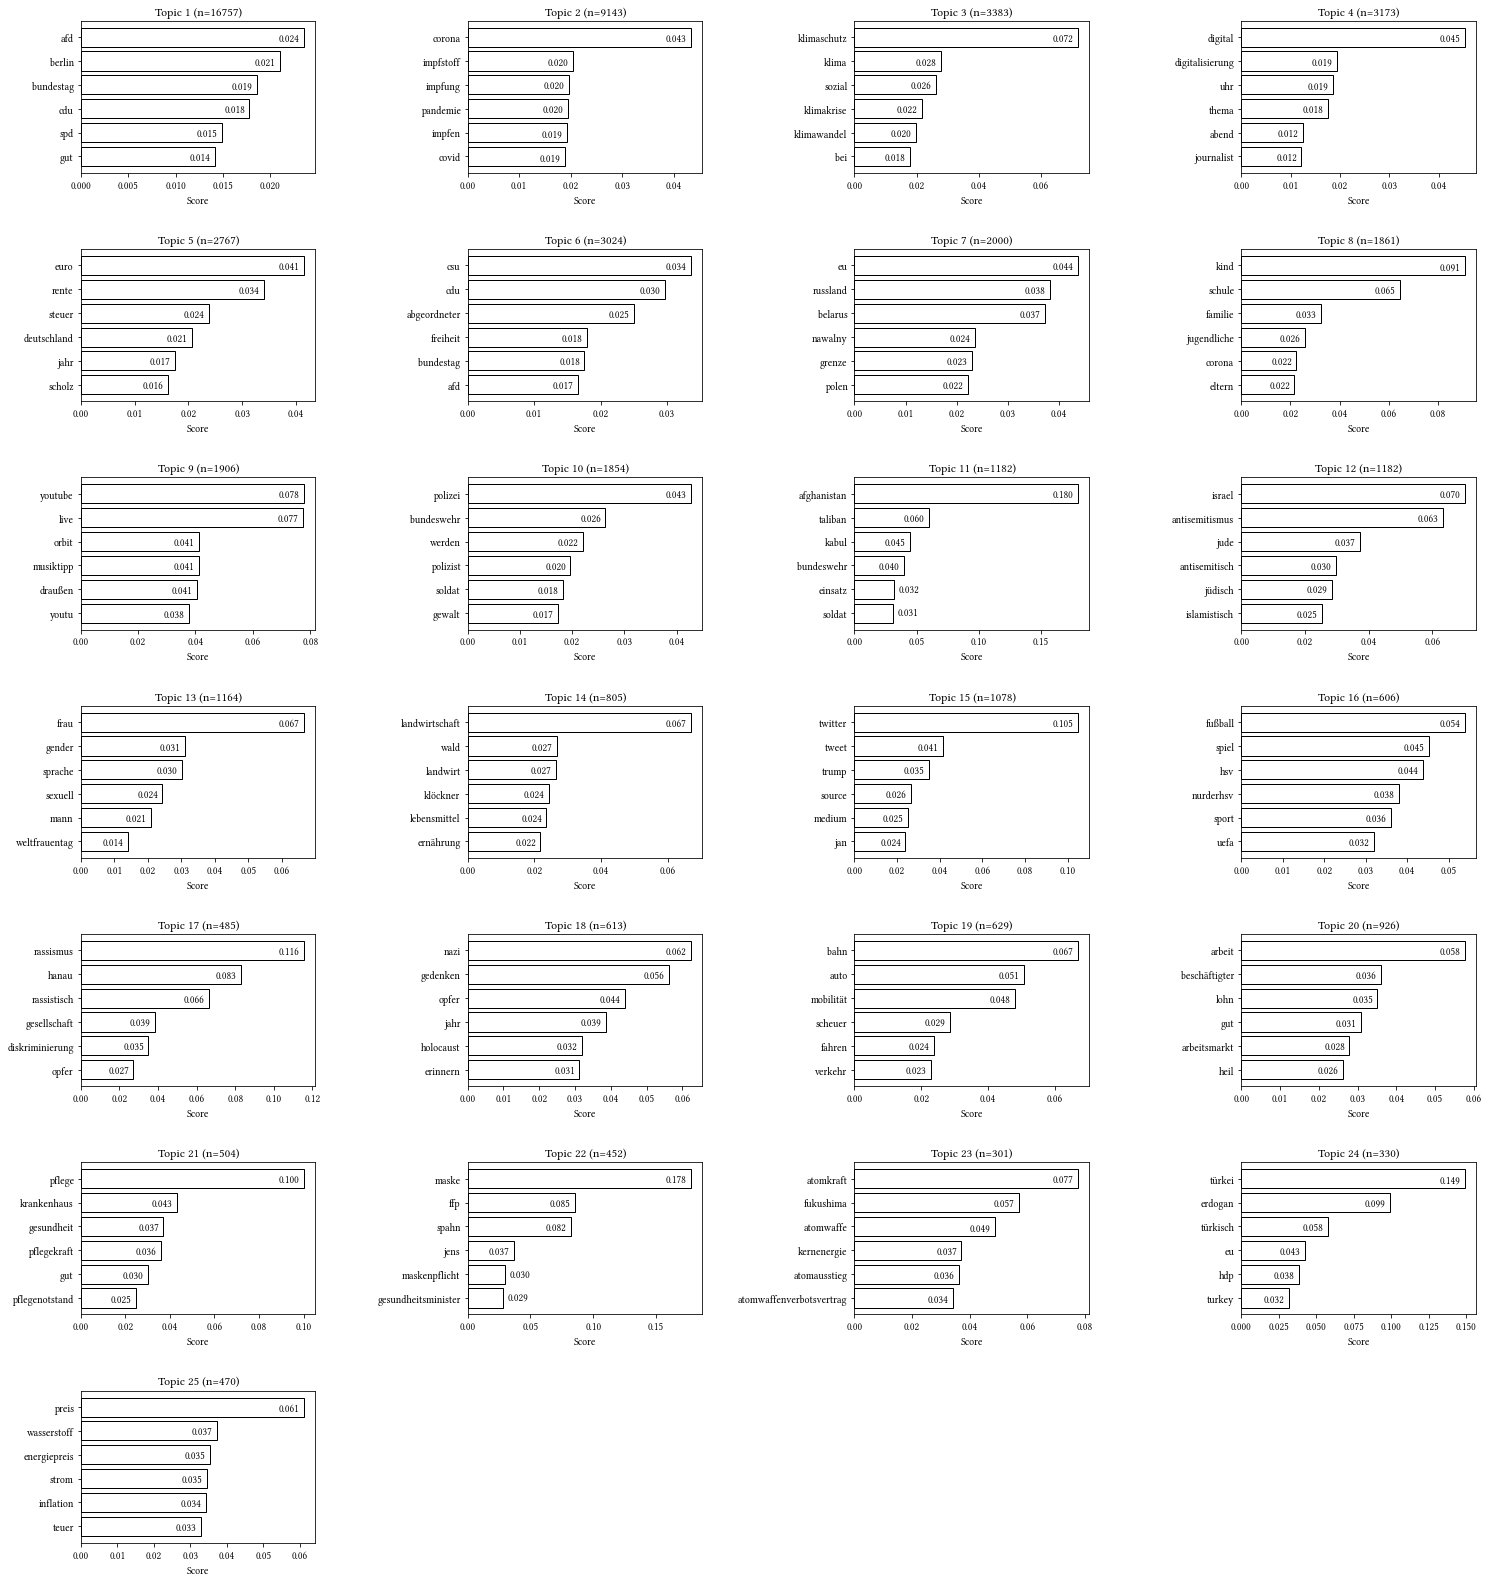

In [34]:
plot_topic_subplots(df_topics, n_topics, document_info["Topic"].value_counts(), filename="results/top5_topics")

A ward linkage function is used to perform the hierarchical clustering based on the cosine distance matrix between topic embeddings.

In [35]:
fig = model.visualize_hierarchy(width=2000, height=2000)
fig.write_html("results/hirachy.html")

Visualize a heatmap of the topic's similarity matrix. Based on the cosine similarity matrix between topic embeddings, a heatmap is created showing the similarity between topics.

In [36]:
fig = model.visualize_heatmap(width=2000, height=2000, top_n_topics=23)#(cleaned_text)
fig.write_html("results/heatmap.html")

### Topics over time

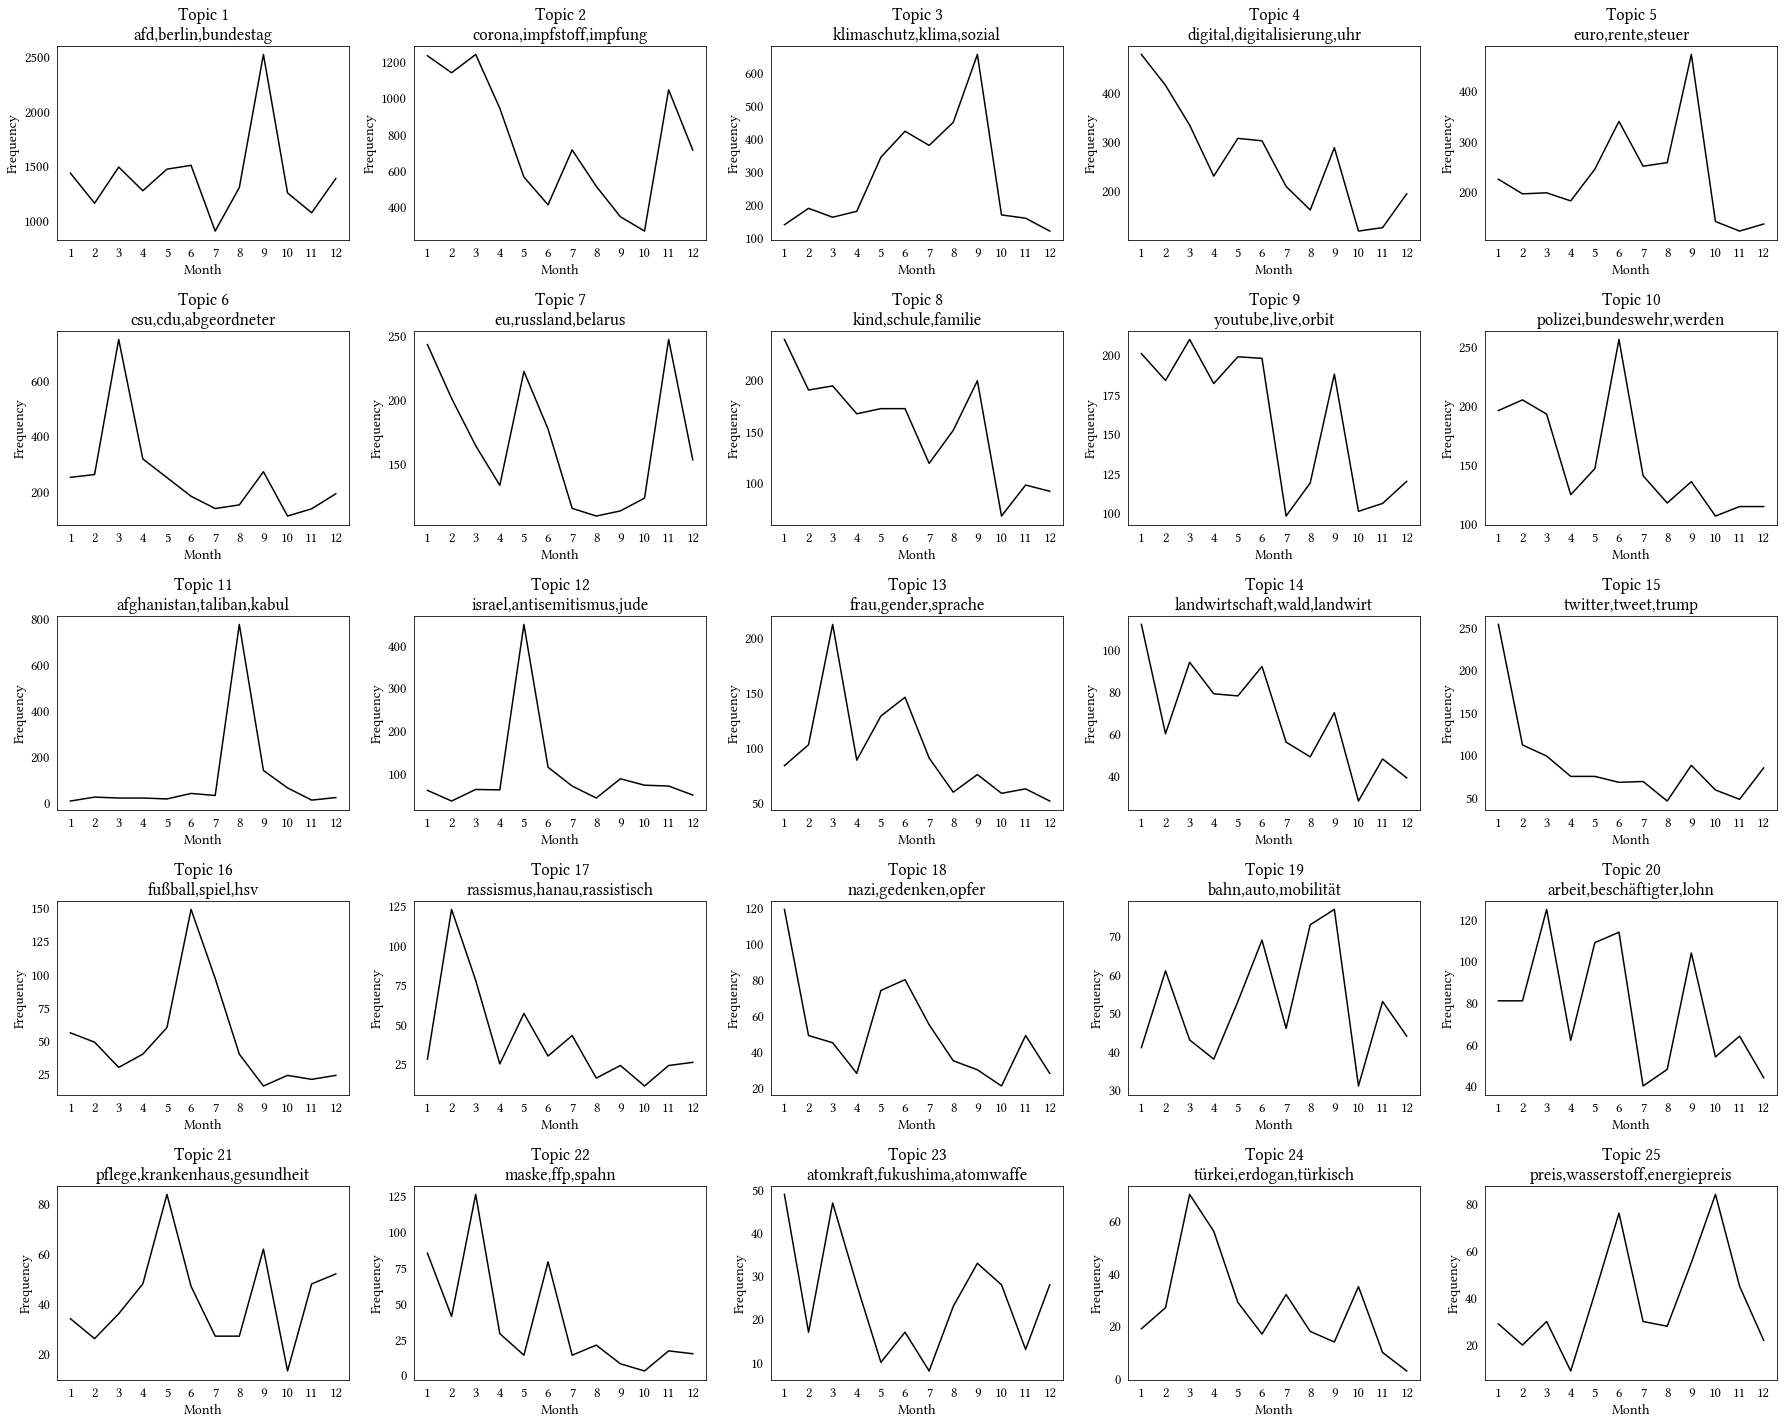

In [37]:
plot_timeseries_subplots(df_topics, n_topics, topics_over_time, filename="results/timeseries_topics")

#### Sentiment Over Time

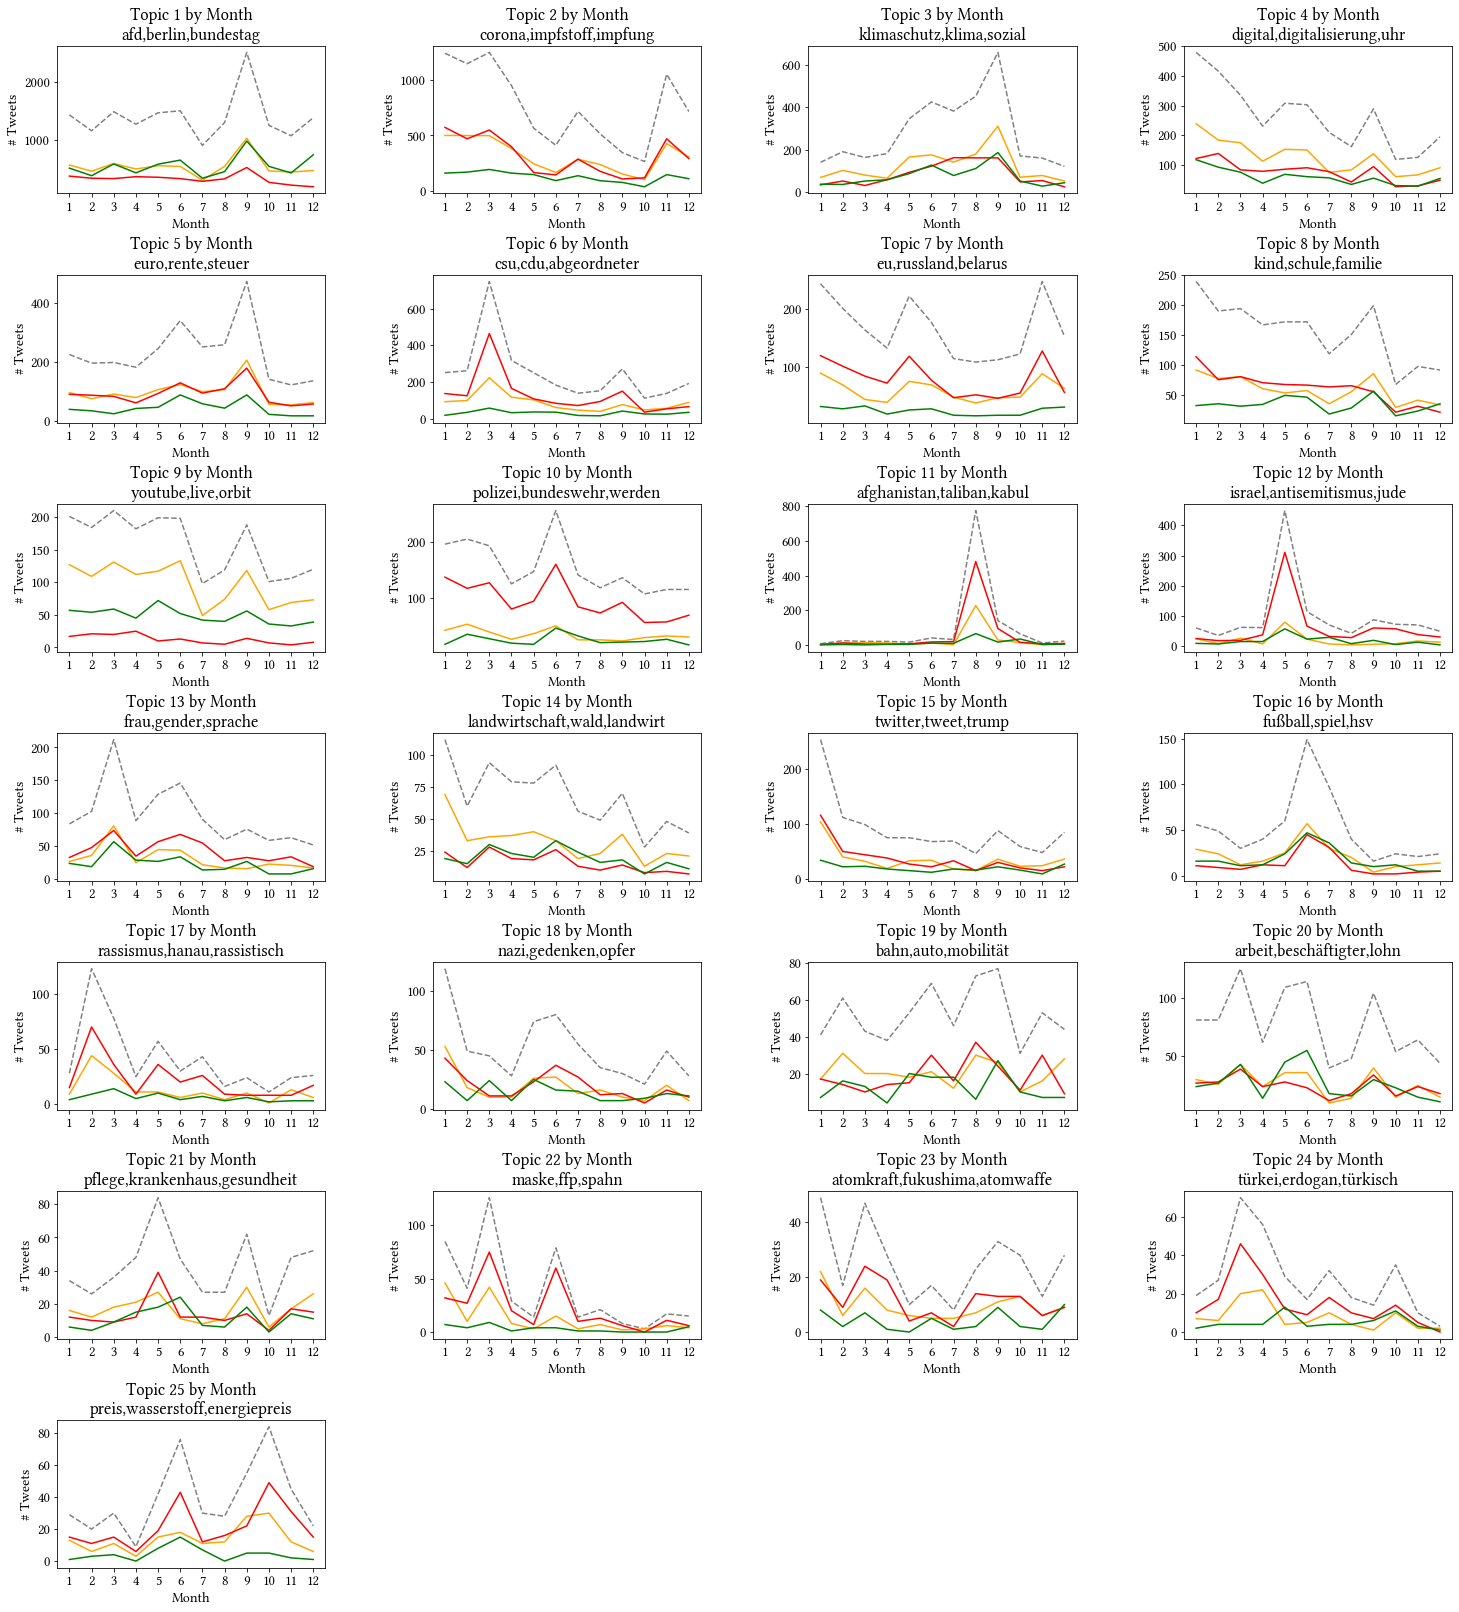

In [38]:
if 'sentiment' in df.columns:
     plot_timeseries_sentiment_subplots(df_topics, n_topics, document_info, topics_over_time, filename="results/timeseries_sentiment_subplots")

### Create Word Clouds

In [39]:
def svg_to_pdf(svg_filepath, pdf_filepath):
    drawing = svg2rlg(svg_filepath)
    renderPDF.drawToFile(drawing, pdf_filepath)

In [40]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wordcloud = WordCloud(background_color="white", max_words=1000, width=1000, height=700, font_path=FONT_PATH_WORDCLOUDS)
    wordcloud.generate_from_frequencies(text)
    
    base_path = f'wordclouds/wordcloud_topic_{topic}'
    
    # Save wordcloud as svg
    wordcloud_svg = wordcloud.to_svg(embed_font=True)
    svg_path = base_path + ".svg"
    f = open(svg_path, "w+")
    f.write(wordcloud_svg)
    f.close()

    # Save wordcloud as png
    png_path = base_path + ".png"
    wordcloud.to_file(png_path)
    
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

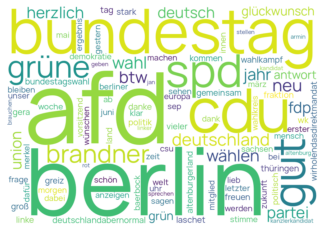

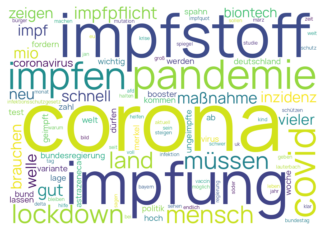

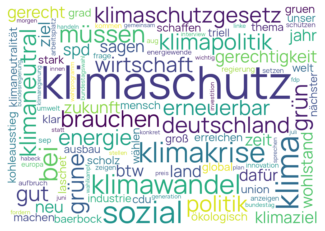

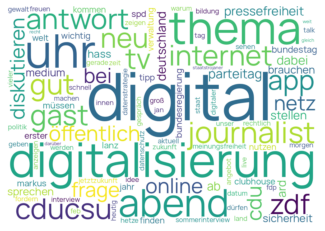

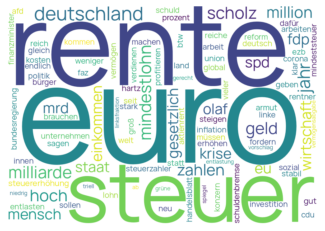

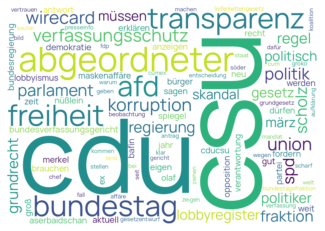

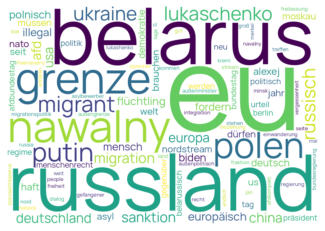

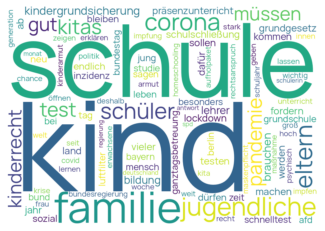

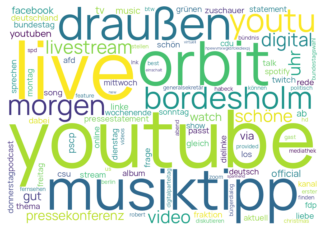

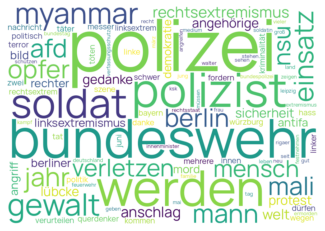

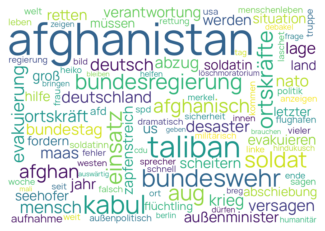

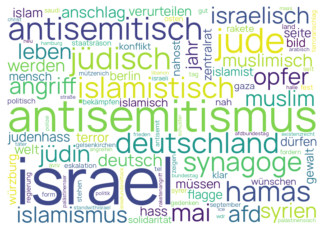

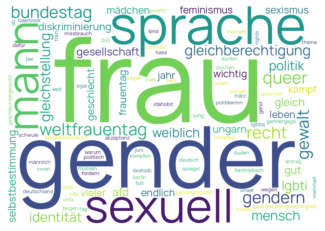

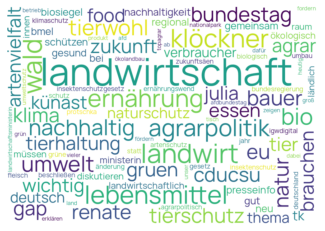

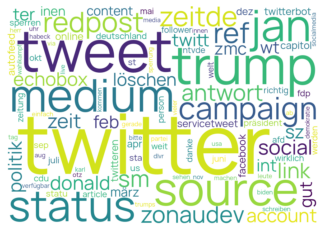

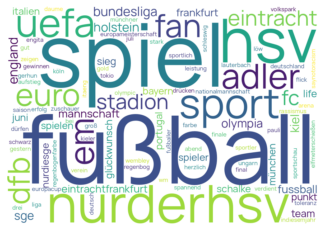

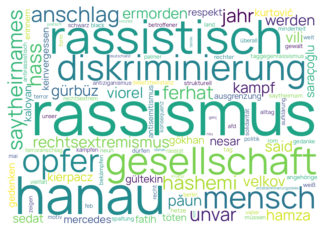

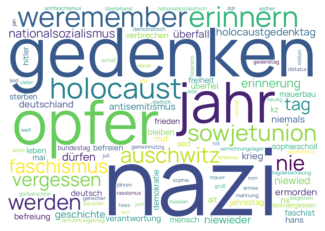

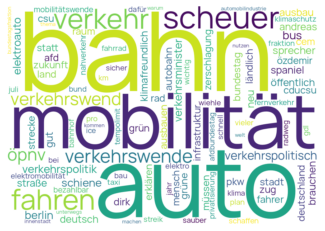

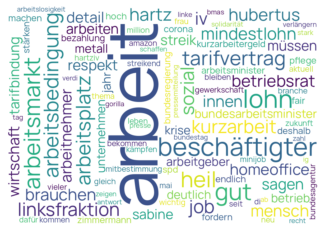

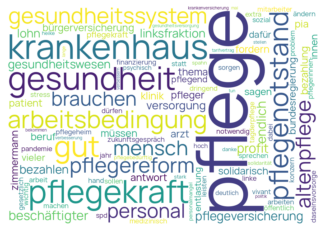

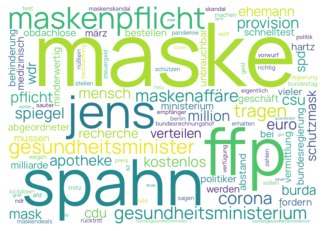

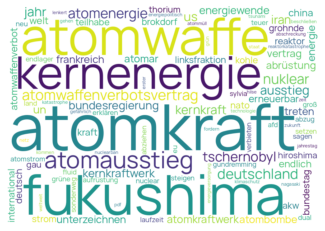

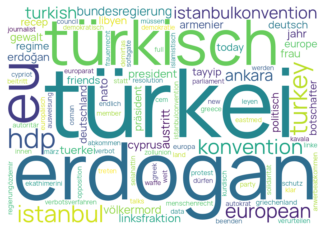

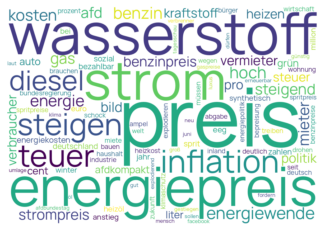

In [41]:
for topic in sorted(document_info["Topic"].unique()):
    create_wordcloud(model, topic=topic)

### Save Model

In [42]:
model.save(MODEL_OUTPUT_PATH)

/opt/conda/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [43]:
#model = BERTopic.load("politician_model")